# Home Depot for Deep Learning Workshop

---


This notebook is the third and finale assignment in the deep learning workshop course in ben gurion university of the negev. It's purpose is to help improve customers shopping experience by developing a model that can accurately predict the relevance of search results. 
details about the dataset and the kaggle competition  can be read more here: https://www.kaggle.com/c/home-depot-product-search-relevance

The note book follows these steps:

1. Naive baseline for the data.
2. using character level embedding with  “Siamese networks” and classic ML models .
3. using word level embedding with  “Siamese networks” and classic ML models.

using colab and google drive - mount the drive to the notebook.

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Imports for all the sections of the notebook. one may choose to divide those but we like it better in one place.

In [0]:
import os
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder

import tensorflow as tf 

from nltk.stem import PorterStemmer

import itertools
from itertools import product

from matplotlib import pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import keras.backend as K 
import time

from sklearn.manifold import TSNE

from numpy import dot
from numpy.linalg import norm

from keras.models import Model , Sequential, load_model
from keras.layers import Input, Embedding, Dense, Flatten, LSTM, dot, Lambda, Dropout
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l2
from keras.utils import to_categorical


Using TensorFlow backend.


Setting the path to use in all the notebook, you can just add your path to ran the notebook if needed.

In [0]:
tal_path = '/content/drive/My Drive/MY DLWS/Home Depot Data/'
doron_path='/content/drive/My Drive/DLWS/Assignment3/Home Depot Data/'

path = tal_path;

This function is meant to used once to preprocess the test dataset with the soultion data which was publish when the compettion was over.

In [0]:
def preprocess_test(path):
  solution = pd.read_csv(path + 'solution.csv', encoding = "ISO-8859-1")
  test = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
  prod_des = pd.read_csv(path + 'product_descriptions.csv', encoding = "ISO-8859-1")


  prod_des.head()
  test = test.merge(prod_des, how='left', on='product_uid')
  solution = solution.merge(test, how='left', on = 'id')
  solution.drop(solution[solution.relevance < 0].index, inplace=True)
  solution.to_csv(path + 'test2.csv', encoding='utf-8')
  

# preprocess_test(path)

Simpe function for plotting the predictions vs the real values to measue and test our models

In [0]:
def plot_predictions(y_pred, y_true, legend='val', idx=100):
  fig = plt.figure()
  plt.title('relevance comparison')
  plt.ylabel('relevance')
  plt.xlabel('sample')
  plt.plot(y_pred[:idx], '-')
  plt.plot(y_true[:idx].values, '--')
  plt.legend([legend + '_pred', legend + '_truth'], loc='upper left')


# **1. NAIVE BASE LINE**

Main idea: count the number of times each word in the search term appeared in the product description and used that simple feature for a linear regression model. 

first we load the datasets of the train process test and product description.

In [0]:
train = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'test2.csv', encoding = "ISO-8859-1")
prod_des = pd.read_csv(path +'product_descriptions.csv')

In [0]:
train = train.merge(prod_des, how='left', on='product_uid')
# test = test.merge(prod_des, how='left', on='product_uid')

We used porter Stemmer to stem the "search_term" and "product_description" columns on the train and test data frames. The idea beyond using stemming before the word count is a usual process in text processing of this format and we used something similar last year when for an IR project.  

In [0]:
ps = PorterStemmer()

def stem_string(words):
  return " ".join([ps.stem(word) for word in words.lower().split()])

def count_words(strs):
  str_search, str_words = strs
  return sum(int(str_search.find(word) >= 0) for word in str_words.split())

In [0]:
train['search_term'] = train['search_term'].apply(stem_string)
train['product_description'] = train['product_description'].apply(stem_string)
test['search_term'] = test['search_term'].apply(stem_string)
test['product_description'] = test['product_description'].apply(stem_string)

print(train.head())

   id  product_uid                                      product_title  \
0   2       100001                  Simpson Strong-Tie 12-Gauge Angle   
1   3       100001                  Simpson Strong-Tie 12-Gauge Angle   
2   9       100002  BEHR Premium Textured DeckOver 1-gal. #SC-141 ...   
3  16       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   
4  17       100005  Delta Vero 1-Handle Shower Only Faucet Trim Ki...   

          search_term  relevance  \
0        angl bracket       3.00   
1           l bracket       2.50   
2           deck over       3.00   
3    rain shower head       2.33   
4  shower onli faucet       2.67   

                                 product_description  
0  not onli do angl make joint stronger, they als...  
1  not onli do angl make joint stronger, they als...  
2  behr premium textur deckov is an innov solid c...  
3  updat your bathroom with the delta vero single...  
4  updat your bathroom with the delta vero single...  


In [0]:
print(test.head())

   Unnamed: 0  id  relevance    Usage  product_uid  \
0           1   4       2.33   Public       100001   
1           2   5       2.33  Private       100001   
2           3   6       2.67  Private       100001   
3           4   7       2.00   Public       100001   
4           6  10       2.67  Private       100003   

                                       product_title  \
0                  Simpson Strong-Tie 12-Gauge Angle   
1                  Simpson Strong-Tie 12-Gauge Angle   
2                  Simpson Strong-Tie 12-Gauge Angle   
3                  Simpson Strong-Tie 12-Gauge Angle   
4  STERLING Ensemble 33-1/4 in. x 60 in. x 75-1/4...   

                 search_term  \
0            metal l bracket   
1            simpson sku abl   
2         simpson strong tie   
3  simpson strong tie hcc668   
4        bath and shower kit   

                                 product_description  
0  not onli do angl make joint stronger, they als...  
1  not onli do angl make joint stro

We added a new feature which was a simple count of the number of words in the search term that appeared in the relevant product description. 

In [0]:
train['ctr_words'] = train[['search_term','product_description']].apply(count_words, axis = 1)
test['ctr_words'] = test[['search_term','product_description']].apply(count_words, axis = 1)

Before using stemming we got on average 5 word count for each search but after the stemming process those number went up to around 8. So it's wasnt that much of an improvement but we could see it  let us 'catch' more words between the search term and product description which we think helped the model(the validation score was a bit higher too)

In [0]:
print(train['ctr_words'].mean())

8.34628106984217


In [0]:
train.drop(['search_term', 'product_description', 'product_title'], inplace = True, axis =1)
y_test = test['relevance']
x_test = test[['product_uid','ctr_words']]

In [0]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train[['product_uid','ctr_words']], train['relevance'], test_size=0.2)


The model that we used was linear regression model from sklearn. We used a train test split with the default values of the sklearn function which resulted in a 75-25 split to the train and validation respectively.

In [0]:
lr = LinearRegression()
start = time.time()
lr.fit(x_train, y_train)
end = time.time()
running_time = end - start

train_preds = lr.predict(x_train)
val_preds = lr.predict(x_val)
test_preds = lr.predict(x_test)

The RMSE and MAE scores for each set is shown below.

In [0]:
print('Running time: {}'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)

Running time: 0.00858449935913086
--------------------------------
Train RMSE loss: 0.527470958457889
Train MAE loss: 0.43371316049325104
--------------------------------
Validation RMSE loss: 0.520578033117195
Validation MAE loss: 0.42684395149197096
--------------------------------
Test RMSE loss: 0.5272142596486072
Test MAE loss: 0.4331432890674516
--------------------------------


Lets plot the first 100 predictions against the real values on the train set

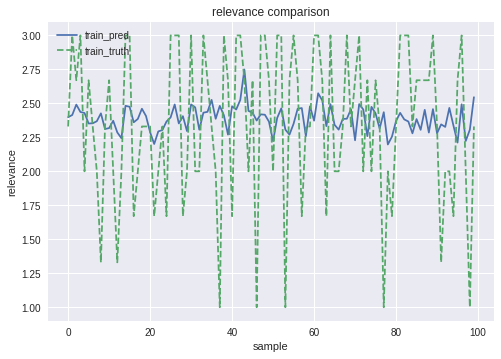

In [0]:
plot_predictions(train_preds,y_train, 'train')

on the validation set

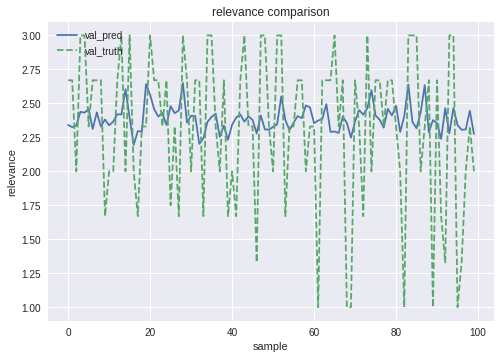

In [0]:
plot_predictions(val_preds,y_val, 'val')

on the test set

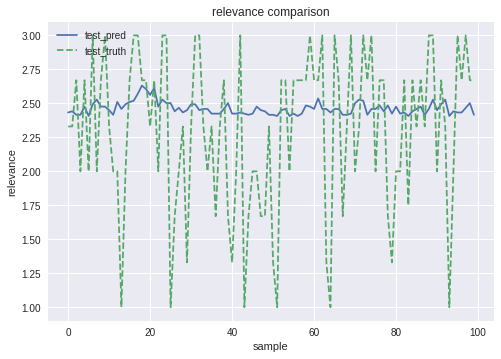

In [0]:
plot_predictions(test_preds,y_test,'test')

# ** 2. Character level Embedding**

main idea: using a character level embedding as input for ANN network and tuse the network as feature extractor.
note: each section is independant of the other ones. we load the data train and so on from scratch in each section.

loading the data and merging with product description.

In [0]:
train = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
prod_des = pd.read_csv(path +'product_descriptions.csv')

In [0]:
train = train.merge(prod_des, how='left', on='product_uid')
test = test.merge(prod_des, how='left', on='product_uid')
train.head()

,id,product_uid,product_title,search_term,relevance,product_description
0,2,100001,Simpson Strong-Tie 12-Gauge Angle,angle bracket,3.00,"Not only do angles make joints stronger, they ..."
1,3,100001,Simpson Strong-Tie 12-Gauge Angle,l bracket,2.50,"Not only do angles make joints stronger, they ..."
2,9,100002,BEHR Premium Textured DeckOver 1-gal. #SC-141 ...,deck over,3.00,BEHR Premium Textured DECKOVER is an innovativ...
3,16,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,rain shower head,2.33,Update your bathroom with the Delta Vero Singl...
4,17,100005,Delta Vero 1-Handle Shower Only Faucet Trim Ki...,shower only faucet,2.67,Update your bathroom with the Delta Vero Singl...


creating a colum of search term and product description combined, this is done in order to later tokenuze all the words in the same manner

In [0]:
data_for_lab = pd.DataFrame()
data_for_lab['dict'] = train['search_term'] + ' ' + train['product_description']
data_for_lab.head()

,dict
0,angle bracket Not only do angles make joints s...
1,l bracket Not only do angles make joints stron...
2,deck over BEHR Premium Textured DECKOVER is an...
3,rain shower head Update your bathroom with the...
4,shower only faucet Update your bathroom with t...


creating a dic of char to labels and another from labels to char

In [0]:
data_string = ''.join(data_for_lab['dict'].tolist())

In [0]:
dict_label_keys = list(set(data_string))
dict_label_idx = LabelEncoder().fit_transform(dict_label_keys)

In [0]:
lbl_to_idx = {key:value for key, value in zip(dict_label_keys,dict_label_idx)}
idx_to_lbl = dict([(value, key) for key, value in lbl_to_idx.items()])

Preparing input and putput for the network as describe in the report.

In [0]:
x_train, y_train = [] , []

for word in data_string.split()[:100000]:
  word = ' ' + word + ' '
  for i in range(1, len(word)-1): 
    prev_char = lbl_to_idx[word[i-1]]
    mid_char = lbl_to_idx[word[i]]
    next_char = lbl_to_idx[word[i+1]]
    
    x_train.append(mid_char)
    y_train.append([prev_char, next_char])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

print(x_train.shape)
print(y_train.shape)

(565707,)
(565707, 2)


In [0]:
y_train_cat1 = to_categorical(y_train[:,0])
y_train_cat2 = to_categorical(y_train[:,1])

print(y_train_cat1.shape)
print(y_train_cat2.shape)

vocab_size = y_train_cat1.shape[1]
vocab_size

(565707, 91)
(565707, 91)


91

The embedding network we use

In [0]:
input_vec = Input(shape=(1,))

emb = Embedding(vocab_size, 16, embeddings_regularizer=l2(1e-3), name='char_embedding')(input_vec)
x = Flatten(name='flatten')(emb)

out_prev = Dense(vocab_size, activation='softmax')(x)
out_next = Dense(vocab_size, activation='softmax')(x)

model = Model(inputs = input_vec, outputs = [out_prev, out_next])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
char_embedding (Embedding)      (None, 1, 16)        1456        input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16)           0           char_embedding[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 91)           1547        flatten[0][0]                    
__________________________________________________________________________________________________
dense_2 (D

In [0]:
history = model.fit(x_train, [y_train_cat1, y_train_cat2], batch_size=128, epochs=3)

Epoch 1/3
565707/565707 [==============================] - 42s 75us/step - loss: 5.5788 - dense_1_loss: 2.7740 - dense_2_loss: 2.7155 - dense_1_acc: 0.2234 - dense_2_acc: 0.2353
Epoch 2/3
565707/565707 [==============================] - 42s 74us/step - loss: 5.1641 - dense_1_loss: 2.5651 - dense_2_loss: 2.5028 - dense_1_acc: 0.2429 - dense_2_acc: 0.2594
Epoch 3/3
565707/565707 [==============================] - 41s 73us/step - loss: 5.1106 - dense_1_loss: 2.5465 - dense_2_loss: 2.4834 - dense_1_acc: 0.2440 - dense_2_acc: 0.2599


In [0]:
x_char = np.array([lbl_to_idx[ch] for ch in dict_label_keys])

In [0]:
encoder = Model(input_vec, x)

In [0]:
embedding = encoder.predict(x_char)
embedding.shape

(94, 16)

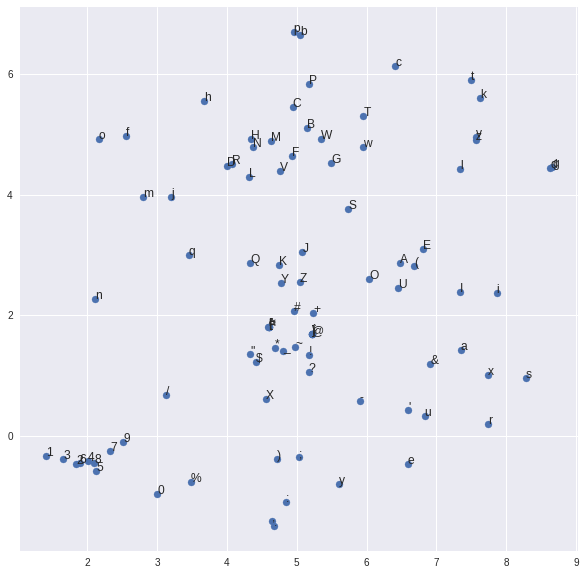

In [0]:
plt.figure(figsize=(10,10))
result = TSNE().fit_transform(embedding)
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(dict_label_keys):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

**Siamese networks**


in this part we use the embedding we created as input for the siamese network. we use the same embedding for the search and description as weve seen in test there isnt much difference.

In [0]:
train = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
prod_des = pd.read_csv(path +'product_descriptions.csv')

In [0]:
train = train.merge(prod_des, how='left', on='product_uid')
# test = test.merge(prod_des, how='left', on='product_uid')

#overide test 
test = pd.read_csv(path + 'test2.csv', encoding = "ISO-8859-1")

In [0]:
x_train = pd.DataFrame();
x_train['left'] = train['search_term']
x_train['right'] = train['product_description']

x_test = pd.DataFrame();
x_test['left'] = test['search_term']
x_test['right'] = test['product_description']

max_seq_length = 20

Helper function for transformig the chars we have into sequnecs of max length we choose.

In [0]:
def chars_to_seq(df, max_seq_length):
  for i, (left,right) in enumerate(zip(df.left, df.right)):
    list_l = list(left)
    list_r = list(right)
    for j, c_l in  enumerate(list_l):
      list_l[j] = lbl_to_idx[c_l]
    for j, c_r in enumerate(list_r):
      list_r[j] = lbl_to_idx[c_r]
    df.left[i] = list_l
    df.right[i] = list_r
    
  df = {'left': df.left, 'right': df.right}
    
  for dataset, side in itertools.product([df], ['left', 'right']):
    dataset[side] = pad_sequences(dataset[side],  maxlen=max_seq_length)
      
  return df
    
    
  
# x_train = chars_to_seq(x_train, max_seq_length)
# x_test = chars_to_seq(x_test, max_seq_length)
y_train = train['relevance']
y_test = test['relevance']

In [0]:
def save_train_test_seq(x_train, x_test, path):
  np.save(path + 'x_train_seq', x_train) 
  np.save(path + 'x_test_seq', x_test) 

# save_train_test_seq 

In [0]:
x_train = np.load(path +'x_train_seq.npy').item()
x_test = np.load(path +'x_test_seq.npy').item()

splitting the data into validation and training 

In [0]:
#train test split

data_len = x_train['left'].shape[0]
train_idx = np.random.RandomState(seed=42).choice(data_len, int(data_len * 0.8), replace=False)
val_idx = np.setdiff1d(range(data_len), train_idx)

x_val = {'left': x_train['left'][val_idx], 'right': x_train['right'][val_idx]}

x_train['left'], x_train['right'] = x_train['left'][train_idx], x_train['right'][train_idx] 

y_train, y_val = y_train[train_idx], y_train[val_idx] 

As mention in the report we tried to create our own custom loss function for this assingmet. the implementaion can be seen below as well as a sanity check we did to see if our loss function idea works. the result werent good so in the end we didnt use it for the final ann model.

In [0]:
def custom_loss(y_true, y_pred):  
  bool_tf_arr = tf.cast(np.abs(y_true - y_pred) > 1, tf.float32)
  
  epsilon = 1e-4
  
  mse_samples = tf.reduce_sum(bool_tf_arr) + epsilon
  mae_samples = tf.cast(tf.size(bool_tf_arr), tf.float32) - mse_samples + epsilon
  
  mse = ((y_true - y_pred) ** 2) * bool_tf_arr
  mae = tf.abs(y_true - y_pred) * (1 - bool_tf_arr)

  tf_res = K.sum(mse) / mse_samples +  K.sum(mae) / mae_samples
  return  tf_res

In [0]:
#Sanity check
tf_res, np_res = 0, 0

import random
random.seed(42)

i = 2 * np.random.sample(10) + 1
j = 2 * np.random.sample(10) + 1

#tensorflow implementation  
with tf.Session() as sess:
  bool_tf_arr = tf.cast(np.abs(i - j) > 1, tf.float64)
  
  epsilon = 1e-4
  
  mse_samples = tf.reduce_sum(bool_tf_arr) + epsilon
  mae_samples = tf.cast(tf.size(bool_tf_arr), tf.float64) - mse_samples + epsilon
  
  mse = ((i - j) ** 2) * bool_tf_arr
  mae = tf.abs(i - j) * (1 - bool_tf_arr)

  tf_res = K.sum(mse) / mse_samples +  K.sum(mae) / mae_samples
  tf_res = sess.run(tf_res)
  
  
#numpy implementation  
bool_np_arr = np.abs(i - j) > 1

epsilon = 1e-4

mse_samples = (bool_np_arr == True).sum() + epsilon
mae_samples = (bool_np_arr == False).sum() + epsilon

mse = ((i - j) ** 2) * bool_np_arr
mae = np.abs(i - j) * (1 - bool_np_arr)

np_res = np.sum(mse) / mse_samples + np.sum(mae) / mae_samples 

print('TF result: {}'.format(tf_res))
print('NP result: {}'.format(np_res))


TF result: 0.4894426933987678
NP result: 0.48943779902077755


Building the siamese network. shared model is the main idea here for the siamese implementaion. we later use cosine similarity and a lamda layer to normalize the output to our problem(1-3 range)

In [0]:
embeddings = model.get_layer('char_embedding').get_weights()[0]
embedding_dim = 16

inp_search = Input(shape=(max_seq_length,), dtype='int32')
inp_des = Input(shape=(max_seq_length,), dtype='int32')

x = Sequential()
x.add(Embedding(len(embeddings), embedding_dim,
                weights=[embeddings], input_shape=(max_seq_length,), trainable=False))

x.add(LSTM(200, name='LSTM'))

shared_model = x

cosine_similarity = dot(inputs = [shared_model(inp_search), shared_model(inp_des)], 
                        axes = -1, normalize = True, name='cosine')

normalize_output = Lambda(lambda x: (x * 2 + 1))(cosine_similarity)


siamese_model = Model(inputs=[inp_search, inp_des], outputs = [normalize_output])

siamese_model.compile(loss = 'mse', optimizer = 'adam')

siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          175056      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
cosine (Dot)                    (None, 1)            0           sequential_1[1][0]               
          

In [0]:
start = time.time()
history = siamese_model.fit([x_train['left'], x_train['right']], y_train,
                            validation_data=([x_val['left'], x_val['right']], y_val ),
                            batch_size = 64, epochs = 10)
end = time.time()

running_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/10
59253/59253 [==============================] - 115s 2ms/step - loss: 0.3083 - val_loss: 0.3038
Epoch 2/10
59253/59253 [==============================] - 111s 2ms/step - loss: 0.2951 - val_loss: 0.2982
Epoch 3/10
59253/59253 [==============================] - 115s 2ms/step - loss: 0.2896 - val_loss: 0.2923
Epoch 4/10
59253/59253 [==============================] - 116s 2ms/step - loss: 0.2832 - val_loss: 0.2937
Epoch 5/10
59253/59253 [==============================] - 116s 2ms/step - loss: 0.2769 - val_loss: 0.2858
Epoch 6/10
59253/59253 [==============================] - 116s 2ms/step - loss: 0.2720 - val_loss: 0.2889
Epoch 7/10
59253/59253 [==============================] - 116s 2ms/step - loss: 0.2661 - val_loss: 0.2806
Epoch 8/10
59253/59253 [==============================] - 115s 2ms/step - loss: 0.2602 - val_loss: 0.2783
Epoch 9/10
59253/59253 [==============================] - 114s 2ms/step - loss: 0.2543 - val_loss: 0.2

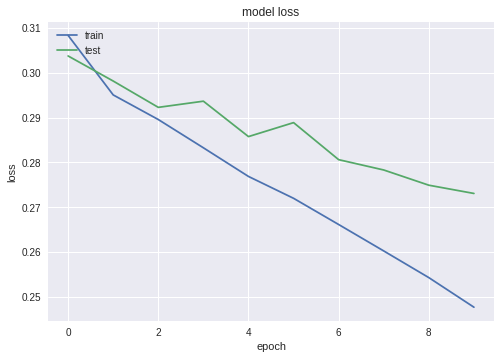

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
# siamese_model.save(path + 'first_model.h5')

In [0]:
siamese_model = load_model(path + 'first_model.h5')

In [0]:
train_preds = siamese_model.predict([x_train['left'], x_train['right']])
test_preds = siamese_model.predict([x_test['left'], x_test['right']])
val_preds = siamese_model.predict([x_val['left'], x_val['right']])

In [0]:
print('Running time: {}s'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)



Running time: 1151.7979772090912s
--------------------------------
Train RMSE loss: 0.4903181826915169
Train MAE loss: 0.40011738754329945
--------------------------------
Validation RMSE loss: 0.5225450774302781
Validation MAE loss: 0.4263533351771243
--------------------------------
Test RMSE loss: 0.5369353088910119
Test MAE loss: 0.43751141981023456
--------------------------------


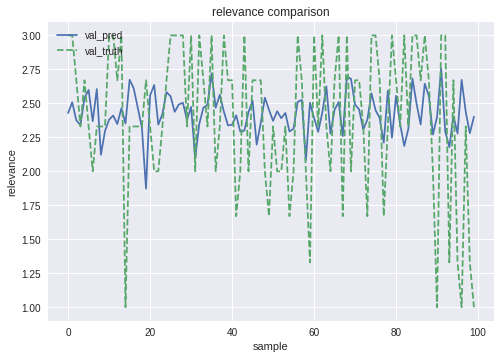

In [0]:
plot_predictions(val_preds, y_val)

In [0]:
# old_model = load_model(path +'first_model.h5')

In [0]:
# siamese_model = old_model
# siamese_model.summary()

**Feature Extractor**


here we use the network as feature extractor for 2 ML algorithms, random forest regressor and xgbregressor. we took the output of the lstm layer in the shared model as feature extractor

loading an already saves network(the best we had)

In [0]:
siamese_model.load_weights(path + 'first_model.h5')

Feature extraction part

In [0]:
ftr_extr = Model(inputs = siamese_model.input, outputs = siamese_model.get_layer('cosine').input) 

As mention in the report at first the classic model did not learn so we took a look at the feture extraction part. we created a function that shoud tell us if the features are the problem or something else.

In [0]:
#if sanity check is true, then its print the model dataset loss, 
#should get identical result for the prediction of the model
#confirms that the fearures extracted correctly.
def get_extr_ftrs(df, model, sanity_check = False):
  preds = ftr_extr.predict([df['left'], df['right']])
  pred1 = np.array(preds[0])
  pred2 = np.array(preds[1])
  ftrs = np.concatenate((pred1, pred2), axis=1)
  
  if(sanity_check):
    cos_sim = lambda a, b : dot(a, b)/(norm(a)*norm(b))
    preds = []
    for p1,p2 in zip(pred1, pred2):
      preds.append(cos_sim(p1,p2) * 2 + 1)
    preds = np.array(preds) 
    print('RMSE: {}'.format(mean_squared_error(preds, y_train)**0.5))
    
  return ftrs

So, it seems the feature extraction works well. we later figure out the problem was the models hyperparmaters we choose.

In [0]:
ftr_train = get_extr_ftrs(x_train, ftr_extr)
ftr_val = get_extr_ftrs(x_val, ftr_extr)
ftr_test = get_extr_ftrs(x_test, ftr_extr)

print(ftr_train.shape)
print(ftr_val.shape)
print(train.shape)


(59253, 400)
(14814, 400)
(74067, 6)


Running xgbRegressor

In [0]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(n_estimators = 40, learning_rate = 0.1, max_depth = 10)

start = time.time()

eval_set = [(ftr_train, y_train), (ftr_val, y_val)]

xgb_model.fit(ftr_train, y_train, eval_metric=['error', 'rmse'], eval_set=eval_set)

end = time.time()

running_time = end - start

[0]	validation_0-error:-1.38082	validation_0-rmse:1.77294	validation_1-error:-1.3849	validation_1-rmse:1.77767
[1]	validation_0-error:-1.38082	validation_0-rmse:1.61039	validation_1-error:-1.3849	validation_1-rmse:1.61595
[2]	validation_0-error:-1.38082	validation_0-rmse:1.46469	validation_1-error:-1.3849	validation_1-rmse:1.47174
[3]	validation_0-error:-1.38082	validation_0-rmse:1.33467	validation_1-error:-1.3849	validation_1-rmse:1.34309
[4]	validation_0-error:-1.38082	validation_0-rmse:1.2192	validation_1-error:-1.3849	validation_1-rmse:1.22903
[5]	validation_0-error:-1.38082	validation_0-rmse:1.11652	validation_1-error:-1.3849	validation_1-rmse:1.12785
[6]	validation_0-error:-1.38082	validation_0-rmse:1.02513	validation_1-error:-1.3849	validation_1-rmse:1.03883
[7]	validation_0-error:-1.38082	validation_0-rmse:0.944258	validation_1-error:-1.3849	validation_1-rmse:0.96036
[8]	validation_0-error:-1.38082	validation_0-rmse:0.872544	validation_1-error:-1.3849	validation_1-rmse:0.891518

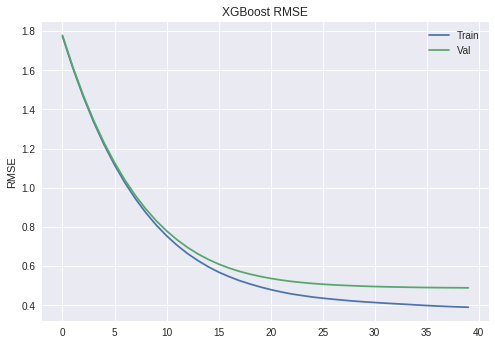

In [0]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [0]:
train_preds = xgb_model.predict(ftr_train)
val_preds = xgb_model.predict(ftr_val)
test_preds = xgb_model.predict(ftr_test)

In [0]:
print('Running time: {}'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)


Running time: 235.1116805076599
--------------------------------
Train RMSE loss: 0.3894864000384748
Train MAE loss: 0.32416903709119144
--------------------------------
Validation RMSE loss: 0.48832708813593007
Validation MAE loss: 0.40267603855666095
--------------------------------
Test RMSE loss: 0.5282434740093834
Test MAE loss: 0.4346251281063211
--------------------------------


Ploting prediction against real values (to see something other than test just swtich the args of the function



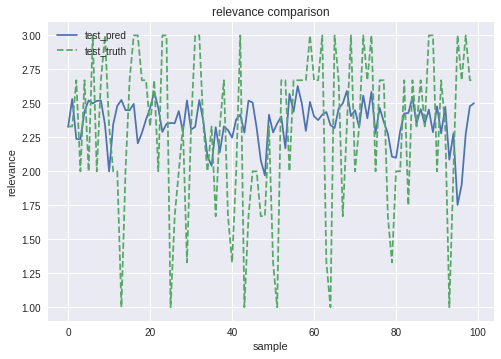

In [0]:
plot_predictions(test_preds, y_test, 'test')

Running random forest

In [0]:
from sklearn.ensemble import RandomForestRegressor

start = time.time()

rfr_model = RandomForestRegressor(n_estimators = 15, max_depth = 10)
rfr_model.fit(ftr_train, y_train)

end = time.time()
running_time = end - start

In [0]:

train_preds = rfr_model.predict(ftr_train)
val_preds = rfr_model.predict(ftr_val)
test_preds = rfr_model.predict(ftr_test)

In [0]:
print('Running time: {}s'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)

Running time: 171.80715656280518s
--------------------------------
Train RMSE loss: 0.4698523672898325
Train MAE loss: 0.38935987107010384
--------------------------------
Validation RMSE loss: 0.4982536654968923
Validation MAE loss: 0.4101006978664676
--------------------------------
Test RMSE loss: 0.530534572129795
Test MAE loss: 0.4360223004401761
--------------------------------


Ploting prediction against real values (to see something other than test just swtich the args of the function

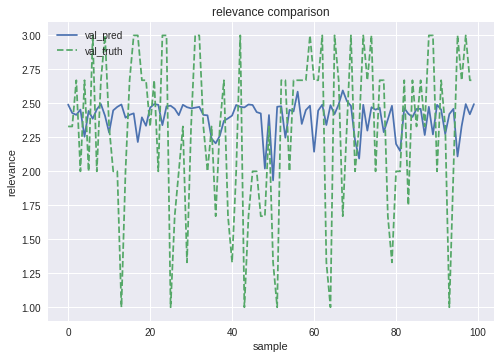

In [0]:
plot_predictions(test_preds, y_test)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Relevance Distribution')

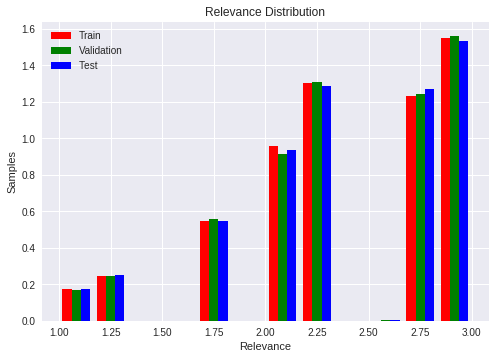

In [0]:
colors = ['r', 'g', 'b']
names = ['Train', 'Validation', 'Test']

plt.hist([y_train, y_val, y_test], bins = int(180/15), normed=True,
         color = colors, label=names)

plt.legend()
plt.xlabel('Relevance')
plt.ylabel('Samples')
plt.title('Relevance Distribution')

# ** 3. Word level Embedding**
​
main idea: using a word level embedding as input for ANN network and use the network as feature extractor.
note: each section is independant of the other ones. we load the data train and so on from scratch in each section.

loading the data

In [0]:
train = pd.read_csv(path + 'train.csv', encoding = "ISO-8859-1")
test = pd.read_csv(path + 'test.csv', encoding = "ISO-8859-1")
prod_des = pd.read_csv(path +'product_descriptions.csv')

In [0]:
train = train.merge(prod_des, how='left', on='product_uid')
test = pd.read_csv(path + 'test2.csv', encoding = "ISO-8859-1")

using keras tokenizer on the search term and product description toghter to create an uniform tokenizer across both columns.

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

embed_size = 100 # how big is each word vector (using glove weights)
maxlen = 60 # max number of words in a question to use (sequence length)


ls = list(train['product_description'].append(train['search_term']).values)
# Tokenize the sentences
tokenizer = Tokenizer(filters='"&*.;?[\]^`{|}~',lower=False)
tokenizer.fit_on_texts(ls)

desc_train = tokenizer.texts_to_sequences(train['product_description'].values)
search_train = tokenizer.texts_to_sequences(train['search_term'].values)
desc_test = tokenizer.texts_to_sequences(test['product_description'].values)
search_test = tokenizer.texts_to_sequences(test['search_term'].values)

In [0]:
y_train = train['relevance']

x_train = pd.DataFrame(columns = ['left', 'right'])
x_train = {'left': x_train.left, 'right': x_train.right}
x_train['left'] = pad_sequences(search_train, maxlen=maxlen)
x_train['right'] = pad_sequences(desc_train, maxlen=maxlen)

y_test = test['relevance']

x_test = pd.DataFrame(columns = ['left', 'right'])
x_test = {'left': x_test.left, 'right': x_test.right}
x_test['left'] = pad_sequences(search_test, maxlen=maxlen)
x_test['right'] = pad_sequences(desc_test, maxlen=maxlen)

train validation split

In [0]:
data_len = x_train['left'].shape[0]
train_idx = np.random.choice(data_len, int(data_len * 0.8), replace=False)
val_idx = np.setdiff1d(range(data_len), train_idx)


x_val = {'left': x_train['left'][val_idx], 'right': x_train['right'][val_idx]}

x_train['left'], x_train['right'] = x_train['left'][train_idx], x_train['right'][train_idx] 

y_train, y_val = y_train[train_idx], y_train[val_idx] 


creating the GloVe embedding vectors from the file. we used glove 100d

In [0]:
embeddings_index = {}
f = open(os.path.join(path, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Creating our embedding matrix using GloVe - words not in GloVe got zero vector

In [0]:
word_index = tokenizer.word_index

embedding_matrix = np.zeros((len(word_index) + 1, embed_size))

unknown_words = 0

for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
      unknown_words += 1
      
unknown_words

219667

In [0]:
print('Well the number of unkown words to glove is {},\nSeems we need to train the embedding as well for epoch or two'.format(len(embeddings_index) - unknown_words))

Well the number of unkown words to glove is 180333,
Seems we need to train the embedding as well for epoch or two


In [0]:
def word_siamese_model(trainable = False, dropout = None):
  inp_search = Input(shape=(maxlen,), dtype='int32')
  inp_des = Input(shape=(maxlen,), dtype='int32')

  x = Sequential()
  x.add(Embedding(len(word_index) + 1, embed_size,
                  weights=[embedding_matrix], input_shape=(maxlen,), trainable=trainable))

  x.add(LSTM(200, name='LSTM'))

  if(dropout):
    x.add(Dropout(dropout))
    
  shared_model = x

  cosine_similarity = dot(inputs = [shared_model(inp_search), shared_model(inp_des)], 
                          axes = -1, normalize = True,name='cosine')

  normalize_output = Lambda(lambda x: (x * 2 + 1))(cosine_similarity)


  siamese_model = Model(inputs=[inp_search, inp_des], outputs = [normalize_output])

  siamese_model.compile(loss = 'mse', optimizer = 'adam')
  
  return siamese_model

# trainable - true - means we want to find representation of the embedding,
# which later we will use those weights for the training of the whole model.
siamese_model = word_siamese_model(True)  
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 200)          24808500    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
cosine (Dot)                    (None, 1)            0           sequential_1[1][0]               
          

In [0]:
history = siamese_model.fit([x_train['left'], x_train['right']], y_train,
                            validation_data=([x_val['left'], x_val['right']], y_val ),
                            batch_size = 128, epochs = 1)


Train on 59253 samples, validate on 14814 samples
Epoch 1/1
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Tensor'>):
<tf.Tensor 'IsVariableInitialized_9:0' shape=() dtype=bool>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "/usr/local/lib/python3.6/dist-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()  File "/usr/local/lib/python3.6/dist-packages/tornado/ioloop.py", line 888, in start
    handler_f

KeyboardInterrupt: ignored

Now we check our embedding represnetation with TSNE

In [0]:
emb_weights = siamese_model.layers[2].layers[0].get_weights()[0] # embedding layer
vocab_size = emb_weights.shape[0]

In [0]:
emb_input = Input(shape=(1,)) 
emb = Embedding(vocab_size, embed_size, embeddings_regularizer = l2(1e-3),
                name = 'word_embedding', weights = [emb_weights])(emb_input)
emb_out = Flatten(name='flatten')(emb)
model = Model(inputs = emb_input, outputs = emb_out)
word_emb_model = Model(inputs = emb_input, outputs = emb_out) 
word_emb_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_26 (InputLayer)        (None, 1)                 0         
_________________________________________________________________
word_embedding (Embedding)   (None, 1, 100)            24567700  
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
Total params: 24,567,700
Trainable params: 24,567,700
Non-trainable params: 0
_________________________________________________________________


In [0]:
words = np.array([value for key, value in word_index.items()])
words_embbeding = word_emb_model.predict(words)

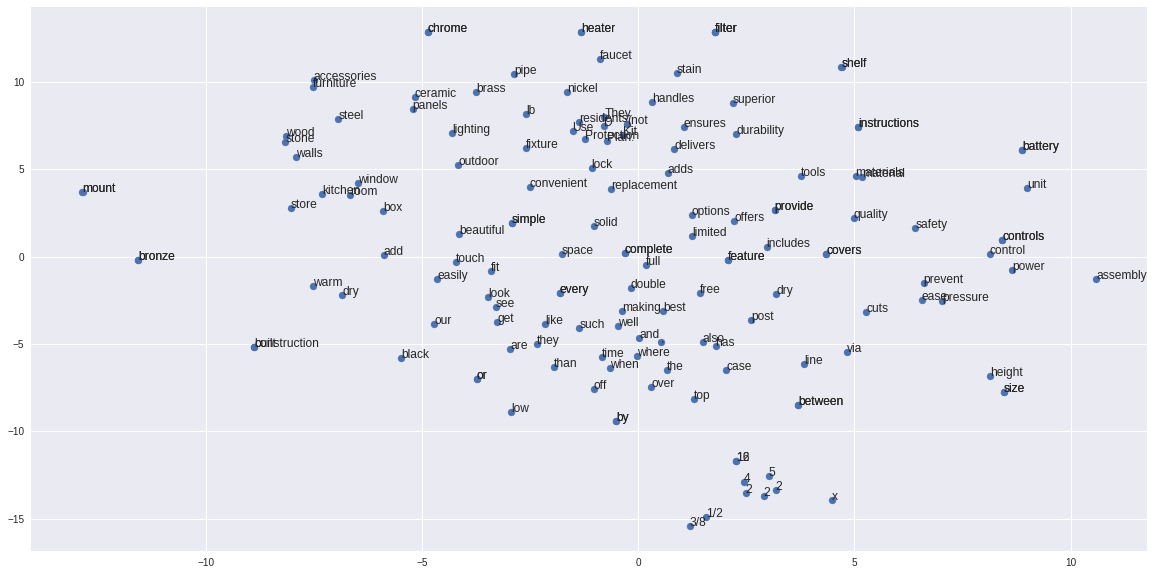

In [0]:
idxs = np.random.randint(500, size=150)

plt.figure(figsize=(20,10))
result = TSNE().fit_transform(words_embbeding[idxs])
plt.scatter(result[:, 0], result[:, 1])
for i, word in enumerate(np.array(list(word_index.keys()))[idxs]):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [0]:
# np.save(path + 'embedding_weights', emb_weights)

In [0]:
embedding_matrix = np.load(path + 'embedding_weights.npy') # embedding_matrix is the variable we initiate the embedding with, at word_siamese_model

In [0]:
siamese_model = word_siamese_model() 
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 60)           0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 200)          24808500    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
cosine (Dot)                    (None, 1)            0           sequential_2[1][0]               
          

We can see that we have reduced the trainable params by setting the embedding layer trainable phase to false,
Now we can train our whole model

In [0]:
start = time.time()
history = siamese_model.fit([x_train['left'], x_train['right']], y_train,
                            validation_data=([x_val['left'], x_val['right']], y_val ),
                            batch_size = 128, epochs = 10)
end = time.time()
running_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/10
59253/59253 [==============================] - 155s 3ms/step - loss: 0.2629 - val_loss: 0.2402
Epoch 2/10
59253/59253 [==============================] - 152s 3ms/step - loss: 0.2372 - val_loss: 0.2336
Epoch 3/10
59253/59253 [==============================] - 149s 3ms/step - loss: 0.2279 - val_loss: 0.2271
Epoch 4/10
59253/59253 [==============================] - 153s 3ms/step - loss: 0.2193 - val_loss: 0.2265
Epoch 5/10
59253/59253 [==============================] - 152s 3ms/step - loss: 0.2113 - val_loss: 0.2201
Epoch 6/10
59253/59253 [==============================] - 150s 3ms/step - loss: 0.2033 - val_loss: 0.2164
Epoch 7/10
59253/59253 [==============================] - 150s 3ms/step - loss: 0.1959 - val_loss: 0.2111
Epoch 8/10
59253/59253 [==============================] - 142s 2ms/step - loss: 0.1894 - val_loss: 0.2094
Epoch 9/10
59253/59253 [==============================] - 130s 2ms/step - loss: 0.1838 - val_loss: 0.2

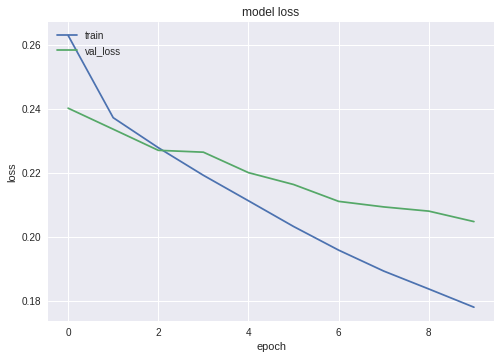

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val_loss'], loc='upper left')
plt.show()

In [0]:
# siamese_model.save(path + 'word_model.h5')

In [0]:
siamese_model = word_siamese_model()
siamese_model.load_weights(path + 'word_model.h5')

In [0]:
train_preds = siamese_model.predict([x_train['left'], x_train['right']])
test_preds = siamese_model.predict([x_test['left'], x_test['right']])
val_preds = siamese_model.predict([x_val['left'], x_val['right']])

In [0]:
print('Running time: {}s'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)

Running time: 1253.5856015487213s
--------------------------------
Train RMSE loss: 0.4179280623452756
Train MAE loss: 0.33792324842985066
--------------------------------
Validation RMSE loss: 0.418706552275427
Validation MAE loss: 0.33962559780724316
--------------------------------
Test RMSE loss: 0.5297903507014284
Test MAE loss: 0.4302584030588484
--------------------------------


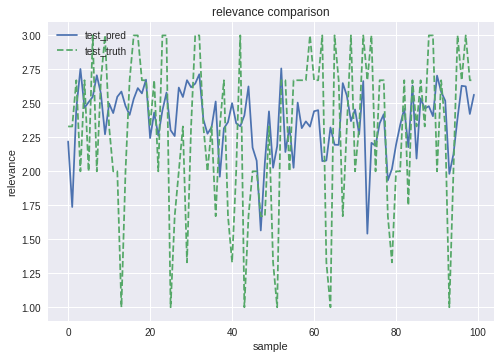

In [0]:
plot_predictions(test_preds, y_test, 'test')

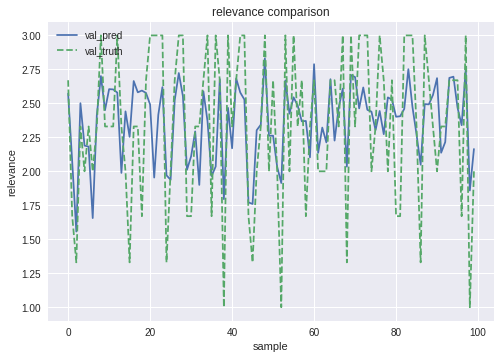

In [0]:
plot_predictions(val_preds, y_val)

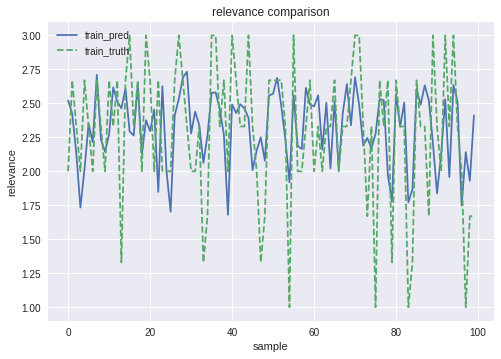

In [0]:
plot_predictions(train_preds, y_train,'train')

Too much overfitting.. Lets train with dropout layer 

In [0]:
siamese_model = word_siamese_model(dropout=0.15) 
siamese_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 60)           0                                            
__________________________________________________________________________________________________
sequential_17 (Sequential)      (None, 200)          24808500    input_33[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
cosine (Dot)                    (None, 1)            0           sequential_17[1][0]              
          

In [0]:
siamese_model.layers[2].layers[2].get_config() #dropout layer details

{'name': 'dropout_7',
 'noise_shape': None,
 'rate': 0.15,
 'seed': None,
 'trainable': True}

In [0]:
start = time.time()
history = siamese_model.fit([x_train['left'], x_train['right']], y_train,
                            validation_data=([x_val['left'], x_val['right']], y_val),
                            batch_size = 128, epochs = 10)
end = time.time()
running_time = end - start

Train on 59253 samples, validate on 14814 samples
Epoch 1/10
59253/59253 [==============================] - 142s 2ms/step - loss: 0.2649 - val_loss: 0.3498
Epoch 2/10
59253/59253 [==============================] - 135s 2ms/step - loss: 0.2419 - val_loss: 0.2911
Epoch 3/10
59253/59253 [==============================] - 136s 2ms/step - loss: 0.2326 - val_loss: 0.3017
Epoch 4/10
59253/59253 [==============================] - 135s 2ms/step - loss: 0.2222 - val_loss: 0.3178
Epoch 5/10
59253/59253 [==============================] - 136s 2ms/step - loss: 0.2134 - val_loss: 0.3250
Epoch 6/10
 9600/59253 [===>..........................] - ETA: 1:43 - loss: 0.2100

KeyboardInterrupt: ignored

We keep to overfit while the validaion loss is not improving

In [0]:
siamese_model = word_siamese_model()
siamese_model.load_weights(path + 'word_model.h5')
# path + 'word_model.h5'

Feature Extractor

In [0]:
ftr_extr = Model(inputs = siamese_model.input, outputs = siamese_model.get_layer('cosine').input) 

ftr_train = get_extr_ftrs(x_train, ftr_extr)
ftr_val = get_extr_ftrs(x_val, ftr_extr)
ftr_test = get_extr_ftrs(x_test, ftr_extr)

In [0]:
from xgboost import XGBRegressor


xgb_model = XGBRegressor(n_estimators = 40, learning_rate = 0.1, max_depth = 10)

start = time.time()

eval_set = [(ftr_train, y_train), (ftr_val, y_val)]

xgb_model.fit(ftr_train, y_train, eval_metric=['error', 'rmse'], eval_set=eval_set)

end = time.time()

running_time = end - start

[0]	validation_0-error:-1.38209	validation_0-rmse:1.77247	validation_1-error:-1.37981	validation_1-rmse:1.77259
[1]	validation_0-error:-1.38209	validation_0-rmse:1.60768	validation_1-error:-1.37981	validation_1-rmse:1.60973
[2]	validation_0-error:-1.38209	validation_0-rmse:1.46014	validation_1-error:-1.37981	validation_1-rmse:1.46433
[3]	validation_0-error:-1.38209	validation_0-rmse:1.32825	validation_1-error:-1.37981	validation_1-rmse:1.33489
[4]	validation_0-error:-1.38209	validation_0-rmse:1.21033	validation_1-error:-1.37981	validation_1-rmse:1.22005
[5]	validation_0-error:-1.38209	validation_0-rmse:1.10519	validation_1-error:-1.37981	validation_1-rmse:1.11796
[6]	validation_0-error:-1.38209	validation_0-rmse:1.01128	validation_1-error:-1.37981	validation_1-rmse:1.02781
[7]	validation_0-error:-1.38209	validation_0-rmse:0.92796	validation_1-error:-1.37981	validation_1-rmse:0.948164
[8]	validation_0-error:-1.38209	validation_0-rmse:0.853853	validation_1-error:-1.37981	validation_1-rms

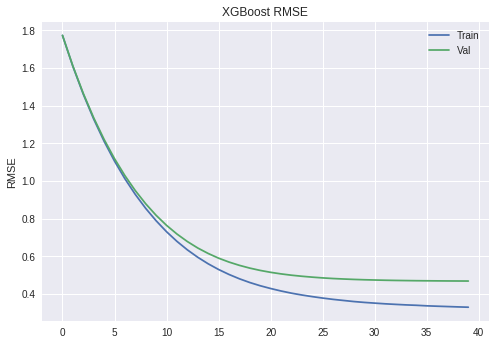

In [0]:
results = xgb_model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Val')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost RMSE')
plt.show()

In [0]:
train_preds = xgb_model.predict(ftr_train)
val_preds = xgb_model.predict(ftr_val)
test_preds = xgb_model.predict(ftr_test)

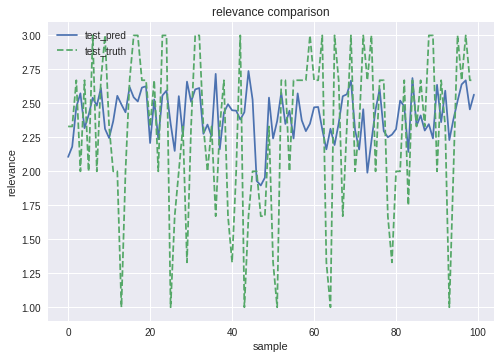

In [0]:
plot_predictions(test_preds, y_test, 'test')

In [0]:
print('Running time: {}s'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))

Running time: 218.33461737632751s
--------------------------------
Train RMSE loss: 0.32928501792424447
Train MAE loss: 0.2715796981882212
--------------------------------
Validation RMSE loss: 0.46826442505436
Validation MAE loss: 0.3803850449089163
--------------------------------
Test RMSE loss: 0.52798676365223
Test MAE loss: 0.4320116999517225


In [0]:
from sklearn.ensemble import RandomForestRegressor

start = time.time()

rfr_model = RandomForestRegressor(n_estimators = 15, max_depth = 10)
rfr_model.fit(ftr_train, y_train)

end = time.time()
running_time = end - start

In [0]:
train_preds = rfr_model.predict(ftr_train)
val_preds = rfr_model.predict(ftr_val)
test_preds = rfr_model.predict(ftr_test)

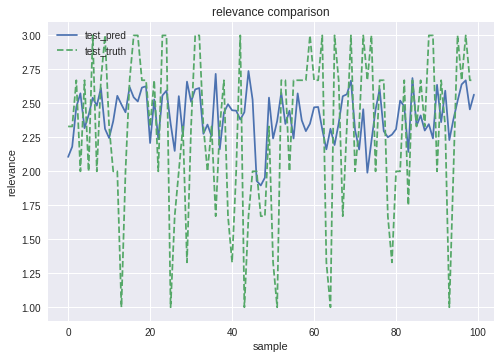

In [0]:
plot_predictions(test_preds, y_test, 'test')

In [0]:
print('Running time: {}s'.format(running_time))
print('-'*32)
print('Train RMSE loss: {}'.format(mean_squared_error(train_preds, y_train)**0.5))
print('Train MAE loss: {}'.format(mean_absolute_error(train_preds, y_train)))
print('-'*32)
print('Validation RMSE loss: {}'.format(mean_squared_error(val_preds, y_val)**0.5))
print('Validation MAE loss: {}'.format(mean_absolute_error(val_preds, y_val)))
print('-'*32)
print('Test RMSE loss: {}'.format(mean_squared_error(test_preds, y_test)**0.5))
print('Test MAE loss: {}'.format(mean_absolute_error(test_preds, y_test)))
print('-'*32)

Running time: 230.9106481075287s
--------------------------------
Train RMSE loss: 0.4190570903812111
Train MAE loss: 0.34332484572853744
--------------------------------
Validation RMSE loss: 0.47434488994457163
Validation MAE loss: 0.38410247922725393
--------------------------------
Test RMSE loss: 0.5257103274194636
Test MAE loss: 0.427543274099431
--------------------------------


Hope you enjoied reading this notebook, as always for any question you can contact tal ben-senior at talbnse@bgu.ac.il at any time!